<a href="https://colab.research.google.com/github/vithushanms/makemore-language-model/blob/main/%5BLanguage_Models%5D_makemore_MLP_Further_Optimization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
#if cloud
from google.colab import drive
drive.mount('/content/drive')
dataFilePath = '/content/drive/My Drive/Publications/Neural Networks Research/makemore: next char prediction language model/names.txt'
words = open(dataFilePath, 'r').read().splitlines() 

Mounted at /content/drive


In [ ]:
# encode chars in the words to integer
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
block_size = 3 

def build_dataset(words):  
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
C = torch.randn((27,10),requires_grad=True)
W1 = torch.randn((30,300), requires_grad=True)
b1 = torch.randn(300, requires_grad=True)
W2 = torch.randn((300, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [ ]:
stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  logits = ((emb.view(-1,dimension) @ W1 + b1).tanh()) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())

In [ ]:
@torch.no_grad()
def split_loss(split):
  X, Y = {
      'test' : { Xtest, Ytest },
      'dev' : { Xdev, Ydev },
      'train': { Xtr, Ytr }
  }[split]
  emb = C[X]
  out_h = (emb.view(-1, dimension) @ W1 + b1).tanh()
  logits = out_h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} : {loss.item()}')

In [ ]:
split_loss('dev')
split_loss('train')

dev : 2.5187299251556396
train : 2.4845380783081055


If we print all the loss in the iteration the loss starts at very high number

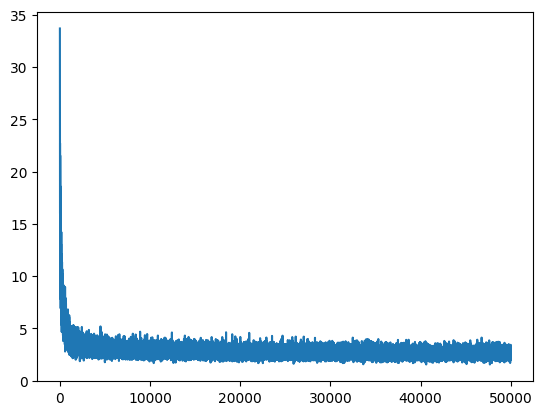

In [ ]:
plt.plot(stepi, lossi)

This makes the model iterate few times unnessesarily and makes the training process more innefficent. therefore we can start from a realistic loss

since we have the 27 characters the releastic probability for the model would be somewhere close to 1/27

In [ ]:
#releastic loss would be close to
-torch.tensor((1/27)).log()

tensor(3.2958)

In [ ]:
#modifyin the last layer's output logits to be very close to 0, then it would probabily
n_emb = 10
n_hidden = 200
C = torch.randn((27,n_emb))
# 228416 * 3 * 10
# 228416 * 1 * 30

W1 = torch.randn((n_emb*3,n_hidden))
# 30 * 200
# 1 * 200 
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch.randn(27) *0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [ ]:
stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  out_h_preactivation = (emb.view(-1,dimension) @ W1 + b1)
  out_h = out_h_preactivation.tanh()
  logits = (out_h) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())

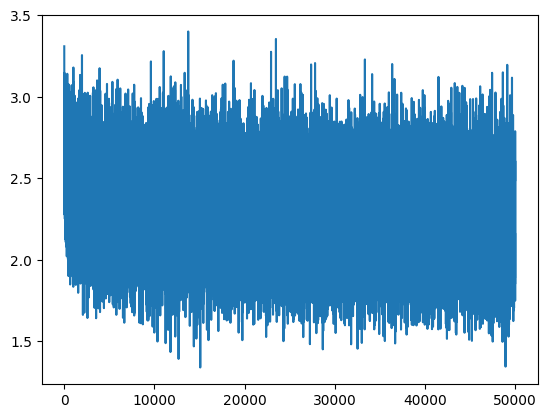

In [ ]:
plt.plot(stepi, lossi)

Now if we look at the output from the hidden layers are basically passing through the tanh function. let's see the values which are coming out from this tanh activation in a histogram 

(array([2653.,  193.,  146.,  115.,   99.,  132.,  123.,  150.,  213.,
        2576.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

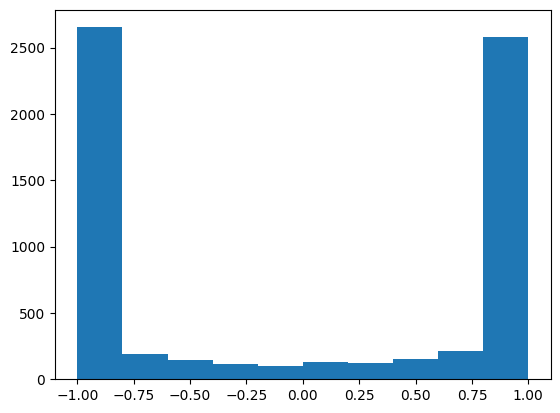

In [ ]:
plt.hist(out_h.view(-1).tolist())

Since most of them are close to 1 and -1, it's not a very good sign

(array([   5.,   75.,  398., 1076., 1975., 1752.,  872.,  209.,   34.,
           4.]),
 array([-21.45720863, -17.05615349, -12.65509834,  -8.2540432 ,
         -3.85298805,   0.54806709,   4.94912224,   9.35017738,
         13.75123253,  18.15228767,  22.55334282]),
 <BarContainer object of 10 artists>)

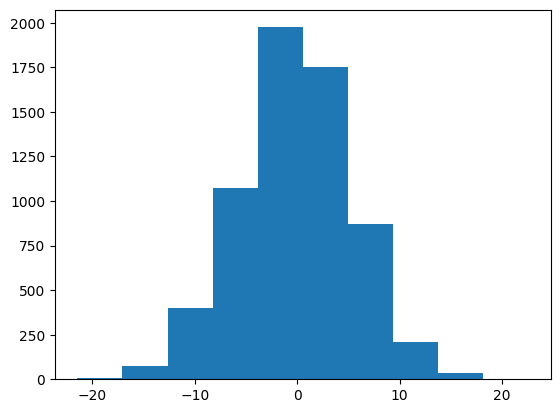

In [ ]:
plt.hist(out_h_preactivation.view(-1).tolist())

The derevative of the tanh is going to be 1 - tanh**2. So, the values which are in the tails which is 1 or -1 from the outcome will be staying in very close to 0 when we backpropogate the tanh function. therefore it never gonna get activated  

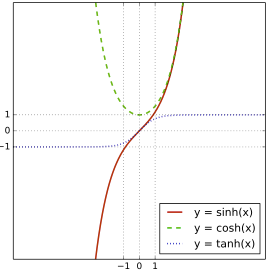

Let's analyze this with respect to our training mini batch during the last iteration

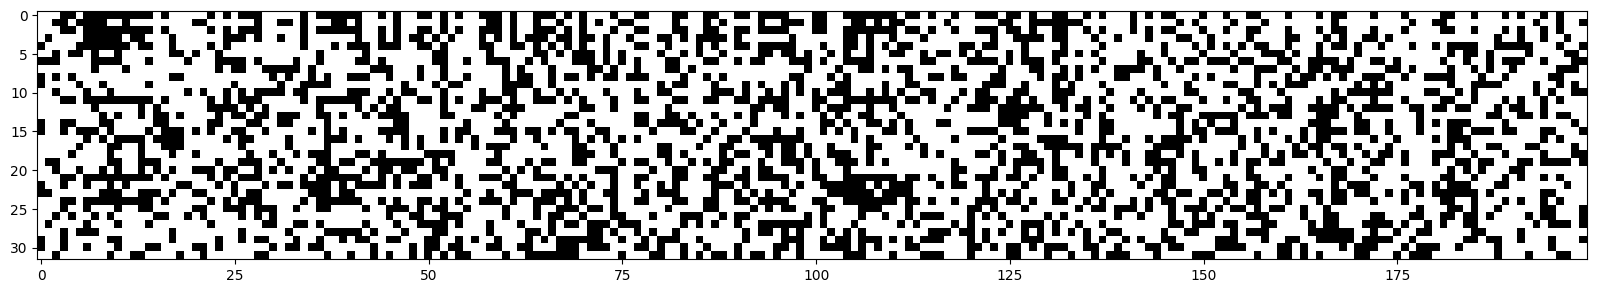

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(out_h.abs() > 0.99, cmap='gray', interpolation='nearest')

#here x axis is going to be the neuron in the hidden layer
#y axis is going to be the concatinated emb values going through the neurons
#the white color boxes are going to be the ones which doesn't activate the neurons, in the other words absolute value of out_h is higher than 0.99 and falling in the flat side of tanh

There we can't see the flat all complete white boxes in any columns. which is kind of a good news 

This conncept will be applicable for other activation non linear activations such as sigmoid, tanh, relu, etc. when the value get fall into flat region of the activation function it's never gonna activbate the neurons


This issue can be fixed by tunning the initial weights and the bias of the layer to be close to zero or very small. because the out_h is coming from the contact emb after going through the weights and bias

In [ ]:
n_emb = 10
n_hidden = 200
C = torch.randn((27,n_emb))
W1 = torch.randn((n_emb*3,n_hidden)) * 0.1
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch.randn(27) *0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  out_h_preactivation = (emb.view(-1,dimension) @ W1 + b1)
  out_h = out_h_preactivation.tanh()
  logits = (out_h) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())



(array([1051.,  367.,  329.,  407., 1142., 1199.,  363.,  282.,  316.,
         944.]),
 array([-9.99999344e-01, -7.99999410e-01, -5.99999475e-01, -3.99999541e-01,
        -1.99999607e-01,  3.27825546e-07,  2.00000262e-01,  4.00000197e-01,
         6.00000131e-01,  8.00000066e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

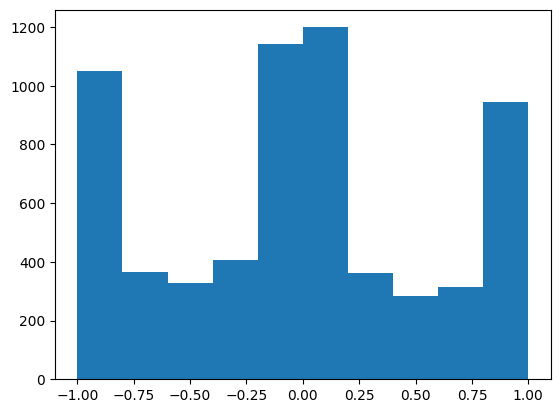

In [ ]:
plt.hist(out_h.view(-1).tolist())

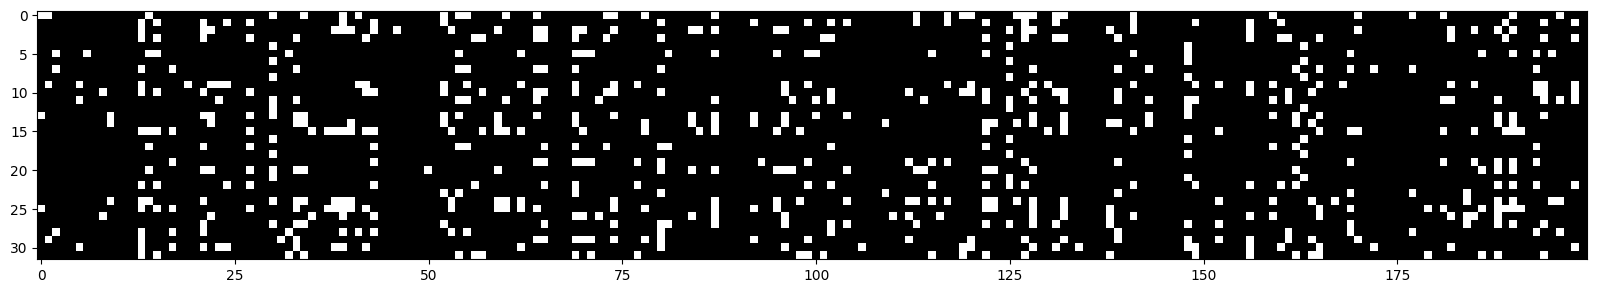

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(out_h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
#when we calculate the loss, now we can see the improvements
split_loss('dev')
split_loss('train')

dev : 2.200483560562134
train : 2.1683590412139893


But the multipliers to scale initial down parameters are not to be hardcoded. therefore we need to identify an automated way to do this

x: mean - -0.005722271744161844 sdx - 1.004833698272705
y: mean - -0.0028853274416178465 sdy - 0.9649483561515808


(array([4.90925811e-05, 1.71824034e-04, 1.71824034e-04, 2.94555487e-04,
        4.66379520e-04, 7.11842426e-04, 9.57305331e-04, 2.23371244e-03,
        3.24011035e-03, 5.37563763e-03, 8.37028508e-03, 1.32304506e-02,
        1.94652084e-02, 2.94310024e-02, 4.56315541e-02, 6.38203554e-02,
        9.02567104e-02, 1.29309859e-01, 1.71799488e-01, 2.31422427e-01,
        2.86258840e-01, 3.46888178e-01, 3.97183527e-01, 4.36555777e-01,
        4.43747841e-01, 4.29191890e-01, 3.88813242e-01, 3.32332228e-01,
        2.76636695e-01, 2.11392654e-01, 1.64263776e-01, 1.22854184e-01,
        8.44637858e-02, 5.97211249e-02, 3.76540097e-02, 2.66081790e-02,
        1.68633016e-02, 1.19049509e-02, 7.33934087e-03, 4.36923972e-03,
        3.16647148e-03, 1.71824034e-03, 1.32549969e-03, 8.10027588e-04,
        3.68194358e-04, 2.70009196e-04, 9.81851622e-05, 0.00000000e+00,
        2.45462906e-05, 2.45462906e-05]),
 array([-4.96962976, -4.765933  , -4.56223623, -4.35853947, -4.1548427 ,
        -3.95114594, 

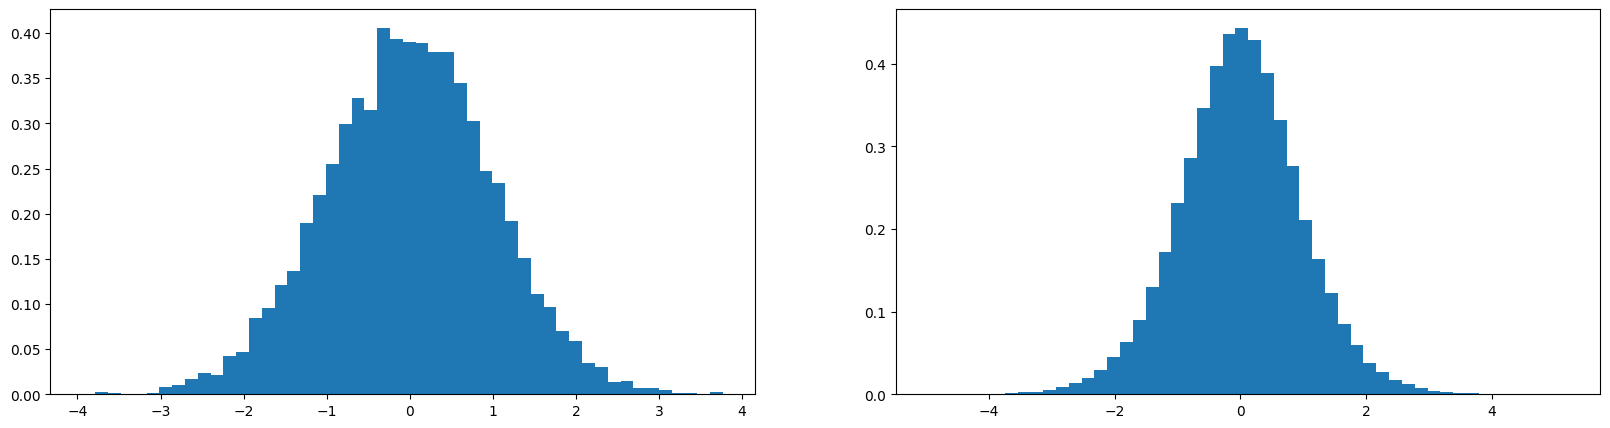

In [ ]:
x = torch.randn(1000,10) 
w = torch.randn(10,200) * 0.3
y = x @ w
print(f'x: mean - {x.mean()} sdx - {x.std()}')
print(f'y: mean - {y.mean()} sdy - {y.std()}')

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)

A Gaussian distribution, also known as a normal distribution, is a probability distribution that is commonly used to model natural phenomena and data in many fields of science and engineering. The distribution is characterized by its bell-shaped curve that is symmetric around the mean.

The Gaussian distribution has two parameters: the mean (μ) and the standard deviation (σ). The mean is the average value of the distribution and represents the center of the curve. The standard deviation is a measure of the spread or dispersion of the data around the mean.

In a Gaussian distribution, approximately 68% of the data falls within one standard deviation of the mean, approximately 95% of the data falls within two standard deviations of the mean, and approximately 99.7% of the data falls within three standard deviations of the mean. This is known as the 68-95-99.7 rule or the empirical rule.

Many natural phenomena and measurements follow a Gaussian distribution, including the heights of people, weights of objects, errors in measurements, and many other physical and biological measurements. Therefore, the Gaussian distribution is widely used in statistical modeling, data analysis, and many other applications.

WHY WE NEED TO USE GUSSIAN DISTRIBUTION: https://arxiv.org/pdf/1502.01852.pdf

x: mean - 0.007140063680708408 sdx - 1.0014582872390747
y: mean - 0.0016750848153606057 sdy - 0.9908379316329956


(array([4.50840454e-05, 0.00000000e+00, 9.01680909e-05, 2.02878205e-04,
        2.47962250e-04, 5.18466523e-04, 6.53718659e-04, 1.51031552e-03,
        2.27674430e-03, 3.85468589e-03, 6.53718659e-03, 1.15865997e-02,
        1.93410555e-02, 2.88763311e-02, 4.49037093e-02, 6.83699549e-02,
        9.82606771e-02, 1.35004174e-01, 1.81846497e-01, 2.40591009e-01,
        3.06954723e-01, 3.59500178e-01, 4.12113259e-01, 4.26224566e-01,
        4.22708010e-01, 3.89052770e-01, 3.40609963e-01, 2.76139778e-01,
        2.13698375e-01, 1.59890567e-01, 1.18999338e-01, 8.23460090e-02,
        5.80907926e-02, 3.53909757e-02, 2.40748803e-02, 1.52834914e-02,
        8.97172504e-03, 5.61296366e-03, 3.47147150e-03, 1.87098789e-03,
        1.32997934e-03, 5.41008545e-04, 3.60672364e-04, 1.57794159e-04,
        1.35252136e-04, 6.76260682e-05, 4.50840454e-05, 2.25420227e-05,
        0.00000000e+00, 2.25420227e-05]),
 array([-5.2723403 , -5.05053234, -4.82872438, -4.60691643, -4.38510847,
        -4.16330051, 

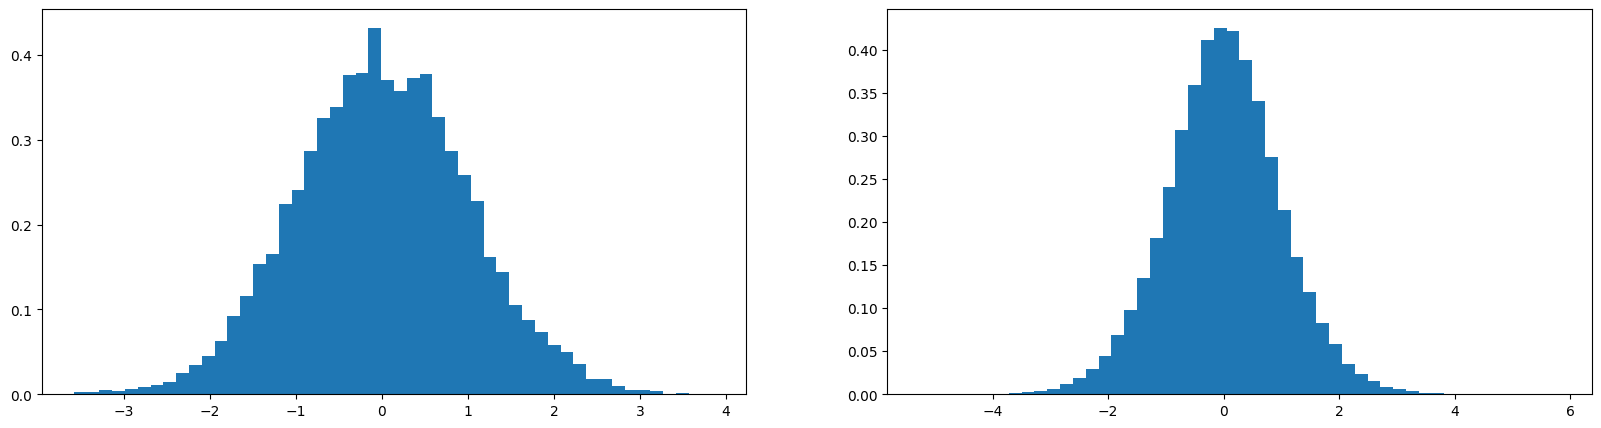

In [ ]:
x = torch.randn(1000,10) 
w = torch.randn(10,200) / 10 ** 0.5
y = x @ w
print(f'x: mean - {x.mean()} sdx - {x.std()}')
print(f'y: mean - {y.mean()} sdy - {y.std()}')

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)

we can use torch.nn.init.kaiming_normal_()

In [ ]:
#so the number is for tanh is going to be 
(5/3) / 30**0.5

0.3042903097250923

This is not really very important these days as the optimization we use later on

Batch normalization: https://arxiv.org/pdf/1502.03167.pdf

This paper eloborate the fact that tuning the preactivation to be gussian and taking the preactivation and making it gusssian are two different operations


In [ ]:
n_emb = 10
n_hidden = 200
C = torch.randn((27,n_emb))
W1 = torch.randn((n_emb*3,n_hidden)) * (5/3) / 30**0.5
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch.randn(27) *0

#scalling shift
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  out_h_preactivation = (emb.view(-1,dimension) @ W1 + b1)

  #normalize pre activation to be gussuan distribution
  out_h_preactivation = (bngain * (out_h_preactivation - out_h_preactivation.mean(0, keepdim=True)) / out_h_preactivation.std(0, keepdim=True)) + bnbias

  out_h = out_h_preactivation.tanh()
  logits = (out_h) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())



In [ ]:
@torch.no_grad()
def split_loss(split):
  X, Y = {
      'test' : { Xtest, Ytest },
      'dev' : { Xdev, Ydev },
      'train': { Xtr, Ytr }
  }[split]
  emb = C[X]
  out_h_preactivation = (emb.view(-1, dimension) @ W1 + b1)
  out_h_preactivation = (bngain * (out_h_preactivation - out_h_preactivation.mean(0, keepdim=True)) / out_h_preactivation.std(0, keepdim=True)) + bnbias
  out_h = out_h_preactivation.tanh()
  logits = out_h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} : {loss.item()}')

In [ ]:
split_loss('train')
split_loss('dev')

train : 2.177306652069092
dev : 2.2004120349884033


In [ ]:
#we can have a unified training gain and the bias for batch
with torch.no_grad():
  emb = C[Xtr]
  h_preactivate = emb.view(emb.shape[0], dimension) @ W1 + b1
  bnmean = h_preactivate.mean(0, keepdim=True)
  bnstd = h_preactivate.std(0, keepdim=True)

In [ ]:
@torch.no_grad()
def split_loss(split):
  X, Y = {
      'test' : { Xtest, Ytest },
      'dev' : { Xdev, Ydev },
      'train': { Xtr, Ytr }
  }[split]
  emb = C[X]
  out_h_preactivation = (emb.view(-1, dimension) @ W1 + b1)
  out_h_preactivation = (bngain * (out_h_preactivation - bnmean) / bnstd) + bnbias
  out_h = out_h_preactivation.tanh()
  logits = out_h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} : {loss.item()}')

split_loss('train')
split_loss('dev')

train : 2.177306652069092
dev : 2.200575113296509


In [ ]:
#we can do the same as running mean and running std in the process of converging 
n_emb = 10
n_hidden = 200
C = torch.randn((27,n_emb))
W1 = torch.randn((n_emb*3,n_hidden)) * (5/3) / 30**0.5
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch.randn(27) *0

#initialise it to be a gussian
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

#scalling shift
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  out_h_preactivation = (emb.view(-1,dimension) @ W1 + b1)
  bnmeani = out_h_preactivation.mean(0, keepdim=True)
  bnstdi = out_h_preactivation.std(0, keepdim=True)

  #normalize pre activation to be gussuan distribution
  out_h_preactivation = (bngain * (out_h_preactivation - bnmeani) / bnstdi) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  out_h = out_h_preactivation.tanh()
  logits = (out_h) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())



In [ ]:
#we can have a unified training gain and the bias for batch
with torch.no_grad():
  emb = C[Xtr]
  h_preactivate = emb.view(emb.shape[0], dimension) @ W1 + b1
  bnmean = h_preactivate.mean(0, keepdim=True)
  bnstd = h_preactivate.std(0, keepdim=True)
bnmean

tensor([[ 0.4478, -0.7780, -0.1741, -0.1745, -0.6885,  0.6972,  0.5403,  0.7098,
          0.7948, -0.4666, -0.0230, -0.1727, -0.6171,  0.9474, -0.2705,  0.3432,
          0.1277, -0.9243, -0.4646,  1.3677,  0.1123,  0.7913,  0.1779,  0.8080,
          0.0693, -1.2969, -0.7230, -1.3133,  0.2198,  0.9579,  0.0564, -1.3792,
         -0.2021,  0.2237, -1.1382, -0.4598,  0.3582, -0.7688,  0.1732, -0.3336,
          1.1064, -0.7920,  0.3561, -0.6859,  0.0729,  0.1761, -0.5090,  0.2803,
         -0.1433,  0.3499, -0.2704,  0.5168,  0.0569,  0.2630, -0.1411,  0.6943,
          0.2171,  0.4540,  0.3542,  0.6009, -1.0366, -0.7583, -1.1772,  0.4815,
          0.1649, -1.2138, -0.6793,  0.5231, -0.1489, -0.5297,  0.2829, -0.4696,
          1.2718,  0.9800,  0.8923, -0.7821,  0.4631,  0.4592, -0.1195, -0.5921,
         -0.5011,  0.2811, -0.6935,  0.0632,  0.0626,  0.1427,  0.6567, -0.5660,
          0.9236,  0.1707,  0.3898,  1.8039,  0.1313, -0.4115, -0.0202, -0.7091,
         -0.3385,  1.0987, -

In [ ]:
bnmean_running

tensor([[ 0.4170, -0.8039, -0.1736, -0.1511, -0.7099,  0.6650,  0.5277,  0.6891,
          0.8545, -0.5004, -0.0140, -0.1461, -0.5961,  0.9347, -0.2662,  0.3034,
          0.1460, -0.9096, -0.4796,  1.3639,  0.0989,  0.8146,  0.1431,  0.7832,
          0.0801, -1.3312, -0.7249, -1.2674,  0.2583,  0.9045,  0.0270, -1.3612,
         -0.1236,  0.1964, -1.1203, -0.4948,  0.3100, -0.7381,  0.1506, -0.4080,
          1.1024, -0.7255,  0.3250, -0.6875,  0.0828,  0.1776, -0.4905,  0.2789,
         -0.1988,  0.3647, -0.2119,  0.5336,  0.0408,  0.3230, -0.1793,  0.6479,
          0.1767,  0.4292,  0.3576,  0.5911, -0.9814, -0.6617, -1.1631,  0.4916,
          0.1392, -1.2258, -0.6818,  0.4851, -0.1605, -0.5100,  0.2512, -0.4484,
          1.2070,  0.9346,  0.8576, -0.7781,  0.4458,  0.4661, -0.0750, -0.5436,
         -0.4902,  0.2773, -0.7110,  0.0707,  0.0970,  0.1148,  0.6328, -0.5576,
          0.9263,  0.1691,  0.4301,  1.8189,  0.1332, -0.4181, -0.0986, -0.7309,
         -0.3032,  1.0732, -

In [ ]:
@torch.no_grad()
def split_loss(split):
  X, Y = {
      'test' : { Xtest, Ytest },
      'dev' : { Xdev, Ydev },
      'train': { Xtr, Ytr }
  }[split]
  emb = C[X]
  out_h_preactivation = (emb.view(-1, dimension) @ W1 + b1)
  out_h_preactivation = (bngain * (out_h_preactivation - bnmean_running) / bnstd_running) + bnbias
  out_h = out_h_preactivation.tanh()
  logits = out_h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} : {loss.item()}')

split_loss('train')
split_loss('dev')

train : 2.1771183013916016
dev : 2.204803943634033


In this neural net the data is already sort of gussian. so the effect impact here is not that much. But in the real life, it would be a challenge with non gussian data. so in those scenarios the batch normalizations would help

Batch normalization has a regularizing effect on neural networks, meaning it can help to prevent overfitting and improve the generalization performance of the model.

The regularization effect of batch normalization arises from the fact that it introduces noise into the network during training. Specifically, the normalization process adds a small amount of random noise to the inputs to each layer, which can help to prevent the network from overfitting to the training data.

In addition to the noise introduced by the normalization process, batch normalization also helps to reduce the internal covariate shift, which can make the training of the network more stable and improve the generalization performance of the model.

Moreover, batch normalization also has an explicit regularization effect through the use of two additional learnable parameters, the scaling and shifting parameters. These parameters allow the network to learn the appropriate scale and shift for the normalized inputs, which can help to prevent the network from becoming too sensitive to small changes in the inputs.

Overall, the regularization effect of batch normalization is one of the key reasons why it has become a popular technique for improving the training and generalization performance of neural networks.

Batch normalization has not been deprecated, and is still a commonly used technique in modern deep learning architectures. In fact, batch normalization is considered to be one of the most effective techniques for improving the training and generalization performance of deep neural networks.

However, there have been some criticisms of batch normalization in certain contexts, particularly when used with small batch sizes or in combination with other regularization techniques. Some researchers have argued that batch normalization can lead to over-regularization in these cases, which can hurt the performance of the model.

Additionally, there have been some proposed alternatives to batch normalization that aim to improve on its performance or address some of its limitations. For example, layer normalization and group normalization are two related techniques that can be used as alternatives to batch normalization in certain contexts.

Despite these criticisms and alternative techniques, batch normalization remains a widely used and effective technique for improving the training and generalization performance of deep neural networks. It is still a fundamental component of many modern deep learning architectures and is likely to remain so for the foreseeable future.

In [ ]:
split_loss('train')
split_loss('dev')

train : 2.1771183013916016
dev : 2.204803943634033


In [ ]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])] 
      out_h_preactivation = emb.view(1, -1) @ W1 + b1
      out_h_preactivation = (bngain * (out_h_preactivation - bnmean_running) / bnstd_running) + bnbias
      h = out_h_preactivation.tanh()
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cex.
maleah.
makilah.
tyha.
emzie.
tea.
nella.
kama.
ar.
semiyah.
jalex.
gotti.
moliselian.
keya.
darea.
emiless.
suhakaviyna.
fobs.
mhina.
emvin.
